<img src="../img/logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales
# Semana 3:
#### Nicolas Pereyra
## Consigna:

### TS3: Simulación de un ADC (cuantización) parte 1/2

En esta tarea simularemos el comportamiento de un ADC y cómo sus parámetros, tamaño de palabra de B bits y frecuencia de muestreo $f_{s}$ afectan a una señal (aproximadamente) analógica.

Para ello se puede analizar una senoidal con los siguientes parámetros:

- frecuencia f0 arbitraria, por ejemplo $f_{0}=\frac{f_{S}}{N}=\Delta f$
- Amplitud normalizada, es decir unitaria

Se pide diseñar un bloque cuantizador que opere sobre una señal discreta en tiempo sR, de forma tal que para un ADC de B bits y rango ±VF, el operador.

$s_{Q}=Q_{B,VF}$ {$sR$}


generará una sQ comprendida entre ±VF y con valores discretos establecidos por el paso de cuantización $q=\frac{2.V_{F}}{2^{B}-1}≈\frac{2.V_{F}}{2^{B-1}}(Volts)$.

Visualice en una misma gráfica sR y sQ, donde se pueda observar que tienen el mismo rango en Volts y el efecto de la cuantización para $V_{F}=2$ Volts y  B = 4, 8 y 16 bits.

Bonus:

- 🤯 Analizar la señal de error $e=s_{Q}−s_{R}$

verificando las descripciones estadísticas vistas en teoría (Distribución uniforme, media, varianza, incorrelación)
## Resolucion:

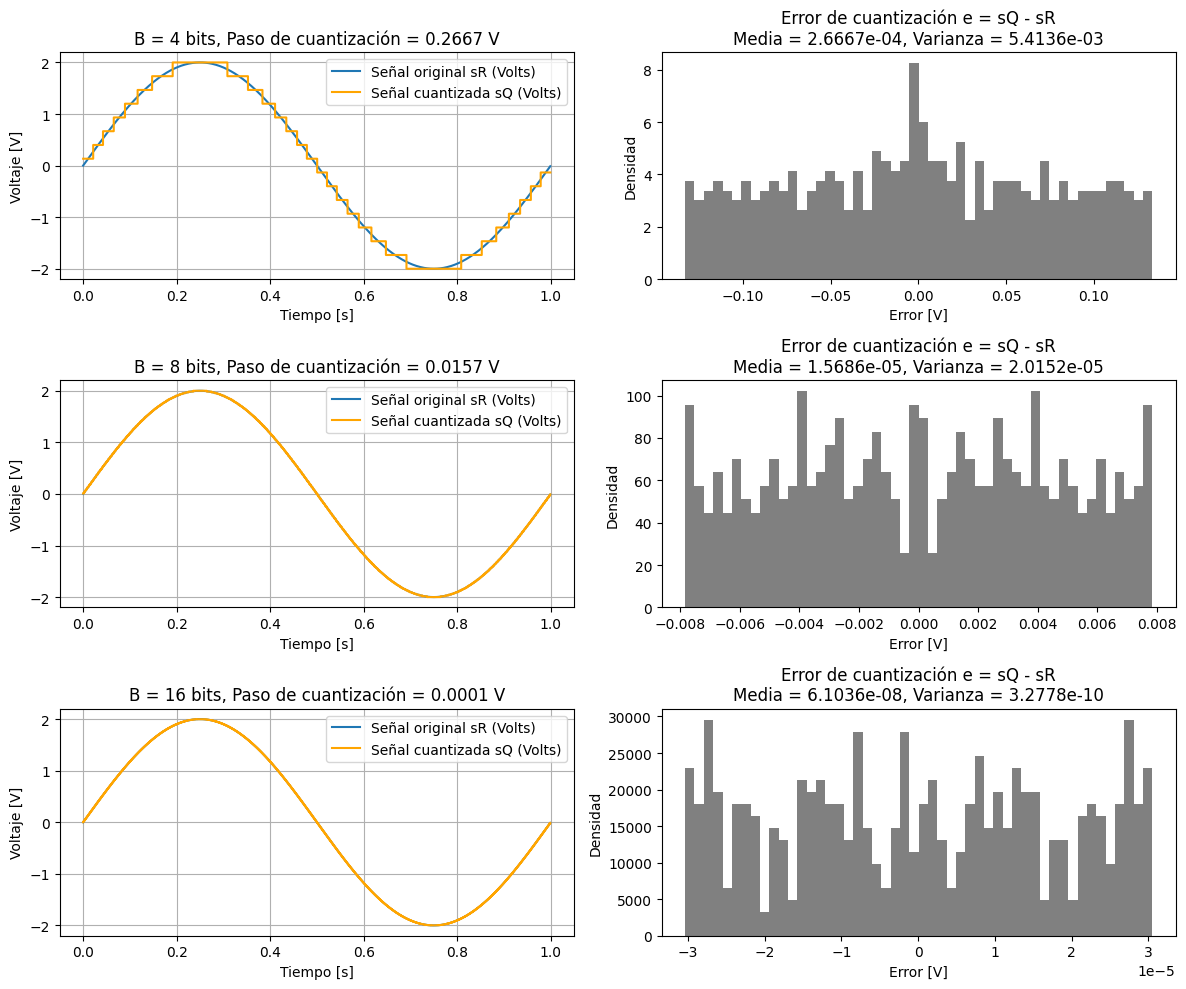

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def mi_funcion_sen(vmax=1, dc=0, ff=1, ph=0, nn=100, fs=1000):
    """
    Realiza una senoidal con los parametros ingresados.
    
    Parámetros:
        vmax: Amplitud máxima de la senoidal
        dc: Valor medio (offset)
        ff: Frecuencia de la señal
        ph: Fase de la señal (radianes)
        nn: Cantidad de muestras
        fs: Frecuencia de muestreo
    
    Retorna:
        tt: Vector de tiempos
        xx: Vector de valores de la señal
    """
    tt = np.arange(nn) / fs
    xx = vmax * np.sin(2 * np.pi * ff * tt + ph) + dc
    return tt, xx

def cuantizar(sR, B, VF):
    """
    Brief:
        Esta función aplica cuantización uniforme a una señal de entrada
        dada una resolución de B bits y un rango máximo de voltaje.

    Parámetros:
        sR (np.ndarray): Señal real de entrada en volts.
        B (int): Cantidad de bits del cuantizador.
        VF (float): Valor máximo del rango del ADC (±VF).

    Retorna:
        sQ (np.ndarray): Señal cuantizada.
        q (float): Paso de cuantización.
    """
    niveles = 2**B
    q = (2 * VF) / (niveles - 1)
    sQ = np.round((sR + VF) / q) * q - VF
    return sQ, q

def analizar_error(sR, sQ):
    """
    Brief:
        Calcula el error de cuantización como la diferencia entre la señal cuantizada
        y la original, y estima su media y varianza.

    Parámetros:
        sR (np.ndarray): Señal original (real).
        sQ (np.ndarray): Señal cuantizada.

    Retorna:
        e (np.ndarray): Vector de errores (sQ - sR).
        media (float): Valor medio del error.
        varianza (float): Varianza del error.
    """
    e = sQ - sR
    media = np.mean(e)
    varianza = np.var(e)
    return e, media, varianza

####
# Parámetros de la señal
fs = 1000         # Frecuencia de muestreo
N = 1000          # Número de muestras
f0 = fs / N       # Frecuencia de la senoidal
VF = 2.0          # Rango del ADC ±VF
vmax = VF         # La amplitud máxima se iguala a VF
dc = 0            # Sin componente DC
ph = 0            # Fase inicial

# Usar la generadora personalizada
t, sR = mi_funcion_sen(vmax=vmax, dc=dc, ff=f0, ph=ph, nn=N, fs=fs)

# Cuantización y gráficos
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
bits = [4, 8, 16]

for i, B in enumerate(bits):
    sQ, q = cuantizar(sR, B, VF)
    e, media, var = analizar_error(sR, sQ)

    axs[i, 0].plot(t, sR, label='Señal original sR (Volts)')
    axs[i, 0].step(t, sQ, where='mid', label='Señal cuantizada sQ (Volts)', color='orange')
    axs[i, 0].set_title(f'B = {B} bits, Paso de cuantización = {q:.4f} V')
    axs[i, 0].set_xlabel('Tiempo [s]')
    axs[i, 0].set_ylabel('Voltaje [V]')
    axs[i, 0].legend()
    axs[i, 0].grid()

    axs[i, 1].hist(e, bins=50, density=True, color='gray')
    axs[i, 1].set_title(f'Error de cuantización e = sQ - sR\nMedia = {media:.4e}, Varianza = {var:.4e}')
    axs[i, 1].set_xlabel('Error [V]')
    axs[i, 1].set_ylabel('Densidad')

plt.tight_layout()
plt.show()


## Espectro:
A continuacion se puede observar un analisis de las anteriores señales pero en el esfectro. Se puede obserbar que al aumentar la cantidad de bits se dismiunuye el piso de ruido.

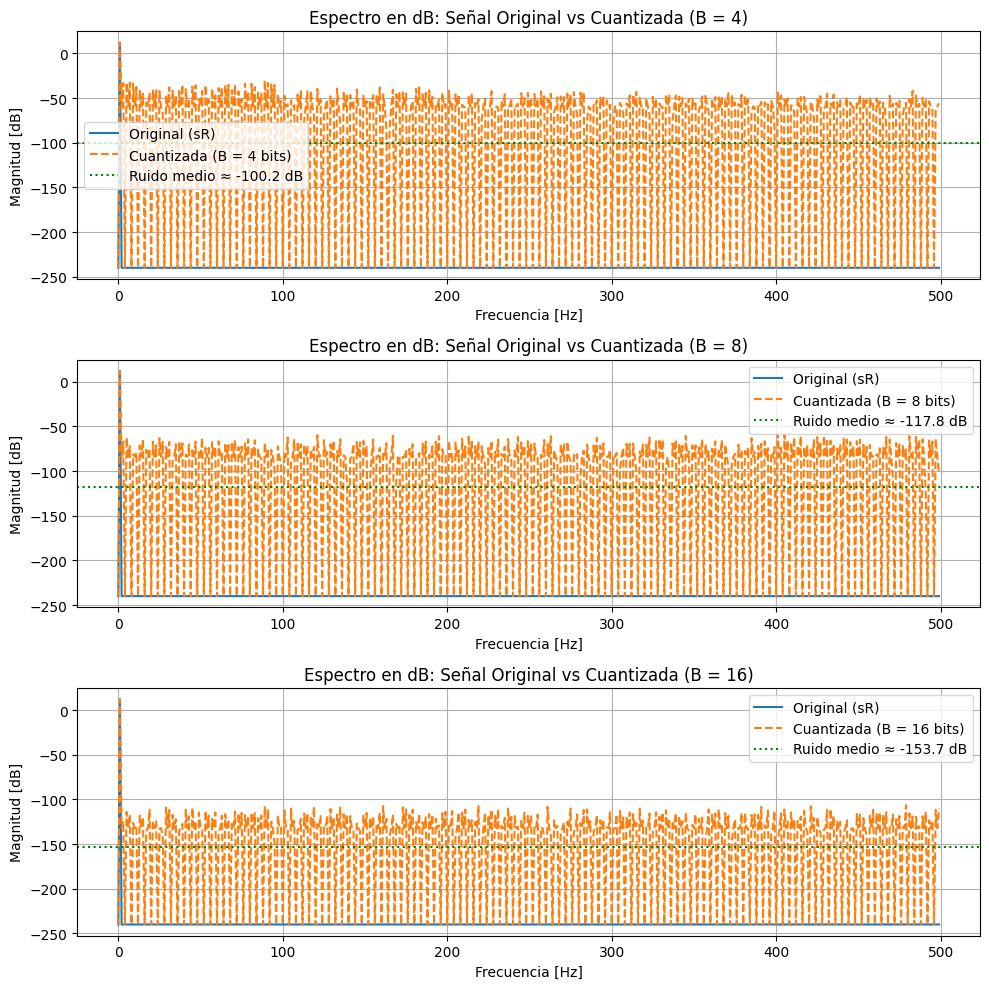

In [15]:
def calcular_fft_db(senal, fs):
    """
    Calcula el espectro en dB de una señal temporal.

    Parámetros:
        senal (np.ndarray): Señal temporal.
        fs (float): Frecuencia de muestreo (Hz).

    Retorna:
        f (np.ndarray): Vector de frecuencias positivas (Hz).
        espectro_db (np.ndarray): Magnitud del espectro en dB.
    """
    N = len(senal)
    fft = np.fft.fft(senal)
    fft_magnitud = np.abs(fft) / N
    fft_magnitud = fft_magnitud[:N//2] * 2  # Espectro unilateral
    f = np.fft.fftfreq(N, 1/fs)[:N//2]
    espectro_db = 20 * np.log10(fft_magnitud + 1e-12)
    return f, espectro_db

fig_fft, axs_fft = plt.subplots(3, 1, figsize=(10, 10))
bits = [4, 8, 16]

# Espectro original
f, espectro_sR = calcular_fft_db(sR * VF, fs)

for i, B in enumerate(bits):
    sQ, _ = cuantizar(sR * VF, B, VF)
    _, espectro_sQ = calcular_fft_db(sQ, fs)

    # Encontrar índice más cercano a la frecuencia f0
    idx_f0 = np.argmin(np.abs(f - f0))

    # Crear copia del espectro y excluir un pequeño rango alrededor de f0
    espectro_sQ_filtrado = np.copy(espectro_sQ)
    ancho = 1  # Rango de frecuencias a excluir alrededor de f0
    espectro_sQ_filtrado[max(0, idx_f0 - ancho): idx_f0 + ancho + 1] = np.nan

    # Calcular promedio sin la frecuencia fundamental
    promedio_db = np.nanmean(espectro_sQ_filtrado)

    axs_fft[i].plot(f, espectro_sR, label='Original (sR)')
    axs_fft[i].plot(f, espectro_sQ, label=f'Cuantizada (B = {B} bits)', linestyle='--')
    axs_fft[i].axhline(promedio_db, color='green', linestyle=':',
                      label=f'Ruido medio ≈ {promedio_db:.1f} dB')
    axs_fft[i].set_title(f'Espectro en dB: Señal Original vs Cuantizada (B = {B})')
    axs_fft[i].set_xlabel('Frecuencia [Hz]')
    axs_fft[i].set_ylabel('Magnitud [dB]')
    axs_fft[i].grid(True)
    axs_fft[i].legend()

plt.tight_layout()
plt.show()
